# Final Data Science Project: Predicting MLB OPS from 2023 Player Stats

## Section 1: Data Importing and Preprocessing (100 Points)

In this section, we will:
- Import and explore the dataset
- Identify data types and dimensions
- Clean and handle missing data
- Transform and normalize skewed variables
- Remove outliers
- Create useful derived features


In [68]:
import sys
print(sys.executable)

import pandas as pd

pd.set_option("display.max_columns", None)
import warnings

import branca
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import xgboost as xgb
from branca.element import Figure
from folium import Marker
from folium.plugins import HeatMap
from scipy.special import boxcox1p
from scipy.stats import norm, probplot, skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import zscore

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.*")
%matplotlib inline


/Users/kentmorris/COMP352-OPS-Final-Project-1/.venv/bin/python


In [73]:
# Load dataset
dfMLB = pd.read_csv("2023MLBBattingStats.csv", encoding='latin1', sep=';')


In [74]:
#check number of rows and columns
dfMLB.shape

(695, 29)

In [75]:
cat_count = 0
for dtype in dfMLB.dtypes:
    if dtype == "object":
        cat_count = cat_count + 1

print("# of categorical variables:", cat_count)

numeric_vars = dfMLB.shape[1] - cat_count - 1
print(
    "# of contineous variables:", numeric_vars
)  # subtract and extra column as 1 column is an ID column

# of categorical variables: 3
# of contineous variables: 25


In [76]:
dfMLB.head()

,Rk,Name,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,1,CJï¿½Abrams*,22,WSN,NL,89,340,316,47,82,17,4,10,39,19,2,13,72,0.259,0.306,0.434,0.739,105,137,5,8,3,0,0
1,2,Josï¿½Abreu,36,HOU,AL,95,400,368,33,90,16,0,8,50,0,1,24,92,0.245,0.293,0.353,0.646,79,130,11,3,0,5,1
2,3,Ronaldï¿½Acunaï¿½Jr.,25,ATL,NL,97,446,391,86,129,26,1,23,58,45,7,49,53,0.330,0.408,0.578,0.986,160,226,7,4,0,2,2
3,4,Willyï¿½Adames,27,MIL,NL,89,383,336,44,71,16,0,17,48,4,3,37,98,0.211,0.291,0.411,0.702,90,138,9,3,0,5,0
4,5,Rileyï¿½Adams,27,WSN,NL,23,87,79,4,22,5,2,3,10,0,0,6,26,0.278,0.337,0.506,0.844,133,40,4,1,1,0,0


In [77]:
# Drop the 'last_name, first_name' and rename 'player_id' to 'Id, rename 'on_base_plus_slg' to 'OPS'
dfMLB = dfMLB.drop(columns=["Rk"])
dfMLB = dfMLB.drop(columns=["Tm"])
dfMLB = dfMLB.drop(columns=["Lg"])

In [78]:
# check the column names
dfMLB.columns

Index(['Name', 'Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP',
       'SH', 'SF', 'IBB'],
      dtype='object')

In [81]:
# Remove spaces from column names
dfMLB.columns = [col.replace(" ", "") for col in dfMLB.columns]
dfMLB.Name = [col.replace("ï¿½", " ") for col in dfMLB.Name]
dfMLB.head()

,Name,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,CJ Abrams*,22,89,340,316,47,82,17,4,10,39,19,2,13,72,0.259,0.306,0.434,0.739,105,137,5,8,3,0,0
1,Jos Abreu,36,95,400,368,33,90,16,0,8,50,0,1,24,92,0.245,0.293,0.353,0.646,79,130,11,3,0,5,1
2,Ronald Acuna Jr.,25,97,446,391,86,129,26,1,23,58,45,7,49,53,0.330,0.408,0.578,0.986,160,226,7,4,0,2,2
3,Willy Adames,27,89,383,336,44,71,16,0,17,48,4,3,37,98,0.211,0.291,0.411,0.702,90,138,9,3,0,5,0
4,Riley Adams,27,23,87,79,4,22,5,2,3,10,0,0,6,26,0.278,0.337,0.506,0.844,133,40,4,1,1,0,0


Handling Missing Data

In [90]:
# List of key columns where zero might be suspicious
key_metrics = ['OBP', 'SLG', 'OPS', 'BA', 'OPS+']

# Convert to numeric if needed
for col in key_metrics:
    dfMLB[col] = pd.to_numeric(dfMLB[col], errors='coerce')

# Count zeros instead of NaNs
total_zeros = (dfMLB[key_metrics] == 0).sum().sort_values(ascending=False)
percent_zeros = ((dfMLB[key_metrics] == 0).sum() / len(dfMLB)).sort_values(ascending=False)

# Combine into a DataFrame
zero_data = pd.concat([total_zeros, percent_zeros], axis=1, keys=["Total Zeros", "Percent Zeros"])
zero_data.head(20)

,Total Zeros,Percent Zeros
OBP,0,0.0
SLG,0,0.0
OPS,0,0.0
BA,0,0.0
OPS+,0,0.0


In [84]:
# Convert rate columns to numeric and treat 0 as missing
rate_cols = ['OBP', 'SLG', 'OPS', 'BA', 'OPS+']
for col in rate_cols:
    dfMLB[col] = pd.to_numeric(dfMLB[col], errors='coerce')
    dfMLB[col] = dfMLB[col].replace(0, pd.NA)

In [91]:
# Drop rows with missing OPS (our prediction target)
dfMLB.dropna(subset=['OPS'], inplace=True)
dfMLB.shape

(592, 26)

In [96]:
# Fill remaining rate-based NaNs with median
for col in rate_cols:
    if dfMLB[col].isnull().sum() > 0:
        dfMLB[col].fillna(dfMLB[col].median(), inplace=True)

In [97]:
# Convert raw numeric columns and fill their NaNs
raw_cols = ['AB', 'PA', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'HBP', 'SF', 'TB', 'RBI', 'SB', 'CS', 'G']
for col in raw_cols:
    dfMLB[col] = pd.to_numeric(dfMLB[col], errors='coerce')
    if dfMLB[col].isnull().sum() > 0:
        dfMLB[col].fillna(dfMLB[col].median(), inplace=True)

In [98]:
# Final dataset info
print("✅ Cleaned dataset shape:", dfMLB.shape)
print("Remaining missing values:", dfMLB.isnull().sum().sum())

✅ Cleaned dataset shape: (467, 26)
Remaining missing values: 0


The Dataset Contains Duplicate Names from in season trades and acquisitions during the season to handle this we will first identify the duplicate names and aggregate those stats for each player and recaluculate OPS metrics

In [ ]:
agg_cols = ['AB', 'PA', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'HBP', 'SF', 'TB', 'RBI', 'SB', 'CS', 'OPS']
df_agg = dfMLB.groupby('Name')[agg_cols].sum().reset_index()

,Name,AB,PA,H,2B,3B,HR,BB,SO,HBP,SF,TB,RBI,SB,CS,OPS
0,scar Mercado,31,32,9,3,0,0,1,4,0,0,12,5,2,1,0.700
1,AJ Pollock,127,138,22,4,0,5,9,30,0,2,41,15,0,1,0.547
2,Aaron Hicks#,390,446,92,12,2,14,54,108,0,2,150,50,6,0,2.049
3,Aaron Judge,175,213,51,10,0,19,35,63,0,3,118,40,3,1,1.078
4,Adam Duvall,132,149,33,11,1,7,10,47,4,3,67,25,3,0,0.823


In [103]:
# Recalculate OPS
df_agg['OBP'] = (df_agg['H'] + df_agg['BB'] + df_agg['HBP']) / (df_agg['AB'] + df_agg['BB'] + df_agg['HBP'] + df_agg['SF'])
df_agg['SLG'] = df_agg['TB'] / df_agg['AB']
df_agg['OPS'] = df_agg['OBP'] + df_agg['SLG']

In [105]:
# Check for remaining nulls
print("Remaining nulls:", df_agg.isnull().sum().sum())

# Check for duplicate names
print("Duplicate names:", df_agg['Name'].duplicated().sum())

# Check that OPS is now filled
print("OPS nulls:", df_agg['OPS'].isnull().sum())

# Confirm shape
print("Final shape:", df_agg.shape)

dfMLB = df_agg

Remaining nulls: 0
Duplicate names: 0
OPS nulls: 0
Final shape: (457, 18)


### Handling Outliers

#### Target Variable

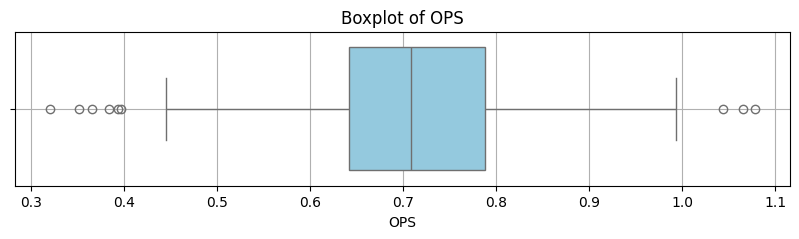

In [121]:

# Create boxplot of OPS Distrubution
plt.figure(figsize=(10, 2))
sns.boxplot(x=dfMLB['OPS'], color="skyblue")

# Customize plot
plt.title('Boxplot of OPS')
plt.xlabel('OPS')
plt.grid(True)
plt.show()

### Potential Outliers are if there are few At Bats Played resulting in a high or low OPS and Overall few at bats played by a player

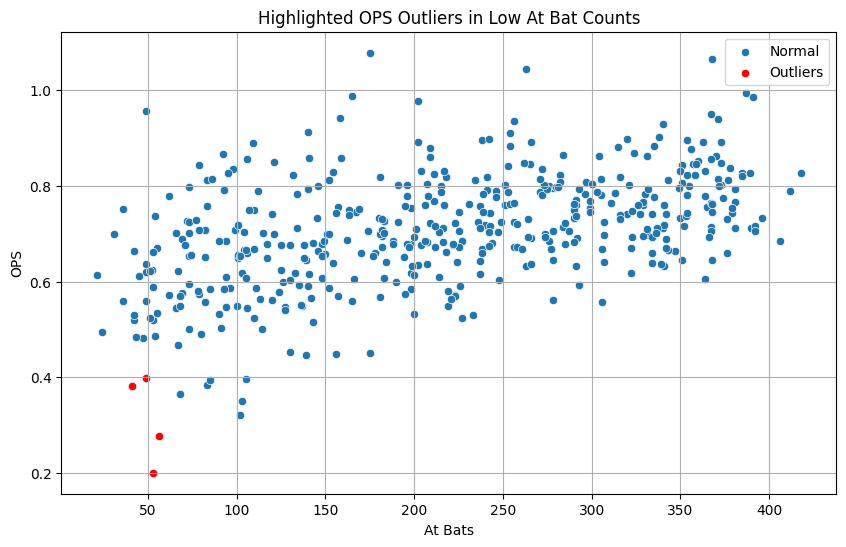

In [116]:
# Identify potential outliers: low games + extreme OPS
# Ensure G and OPS are numeric
dfMLB['AB'] = pd.to_numeric(dfMLB['AB'], errors='coerce')
dfMLB['OPS'] = pd.to_numeric(dfMLB['OPS'], errors='coerce')

# Drop rows with missing G or OPS
dfMLB = dfMLB[dfMLB['AB'].notna() & dfMLB['OPS'].notna()]

# Identify outliers: extreme OPS with few at bats played
outlier_candidates = dfMLB[(dfMLB['AB'] <= 60) & ((dfMLB['OPS'] > 1.0) | (dfMLB['OPS'] < 0.4))]

# Plot all points
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dfMLB, x='AB', y='OPS', label='Normal')

# Highlight outliers
sns.scatterplot(data=outlier_candidates, x='AB', y='OPS', color='red', label='Outliers')

# Customize plot
plt.title('Highlighted OPS Outliers in Low At Bat Counts')
plt.xlabel('At Bats')
plt.ylabel('OPS')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
# Ensure 'G' and 'OPS' are numeric
dfMLB['AB'] = pd.to_numeric(dfMLB['AB'], errors='coerce')
dfMLB['OPS'] = pd.to_numeric(dfMLB['OPS'], errors='coerce')

# Drop rows with missing values in those columns
dfMLB = dfMLB[dfMLB['AB'].notna() & dfMLB['OPS'].notna()]

# Create a Boolean mask for the outliers
outlier_mask = (dfMLB['AB'] <= 60) & ((dfMLB['OPS'] > 1.0) | (dfMLB['OPS'] < 0.4))

# Apply the inverse of the mask to filter them out
dfMLB_cleaned = dfMLB[~outlier_mask]

# Show results
print("Original shape:", dfMLB.shape)
print("Cleaned shape:", dfMLB_cleaned.shape)
print("Removed rows:", dfMLB.shape[0] - dfMLB_cleaned.shape[0])

# Overwrite dfMLB if desired
dfMLB = dfMLB_cleaned

Original shape: (457, 18)
Cleaned shape: (453, 18)
Removed rows: 4


### Normalize Target Variable
Normalizing the target variable is important for linear model performance. It does not have an impact for tree models, thus it is best practice to do so for preprocessing.

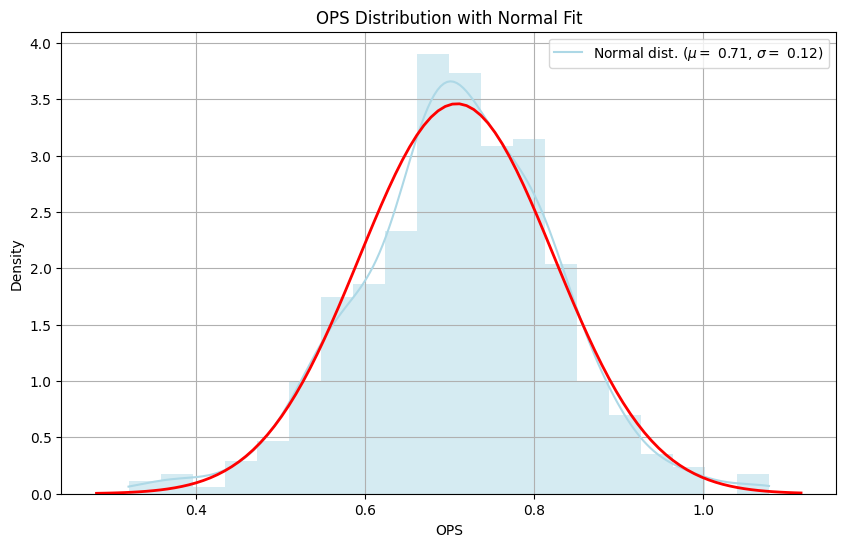

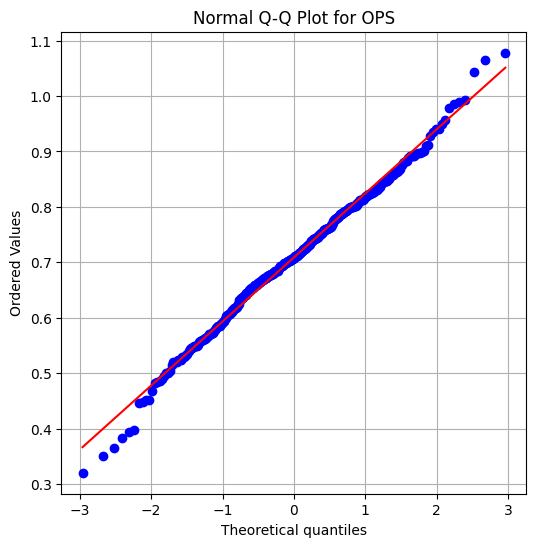

In [122]:
#Plot histogram with normal fit
plt.figure(figsize=(10, 6))
sns.histplot(dfMLB["OPS"], kde=True, stat="density", linewidth=0, color="lightblue")

# Fit normal distribution to OPS
mu, sigma = norm.fit(dfMLB["OPS"])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)

# Labels and legend
plt.legend([r"Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f})".format(mu, sigma)], loc="best")
plt.xlabel("OPS")
plt.ylabel("Density")
plt.title("OPS Distribution with Normal Fit")
plt.grid(True)
plt.show()

# Q-Q plot for OPS
plt.figure(figsize=(6, 6))
probplot(dfMLB["OPS"], dist="norm", plot=plt)
plt.title("Normal Q-Q Plot for OPS")
plt.grid(True)
plt.show()

## Data Analysis and Visualization <a class="anchor" id="data-vis"></a>

Target Variable Scatterplots

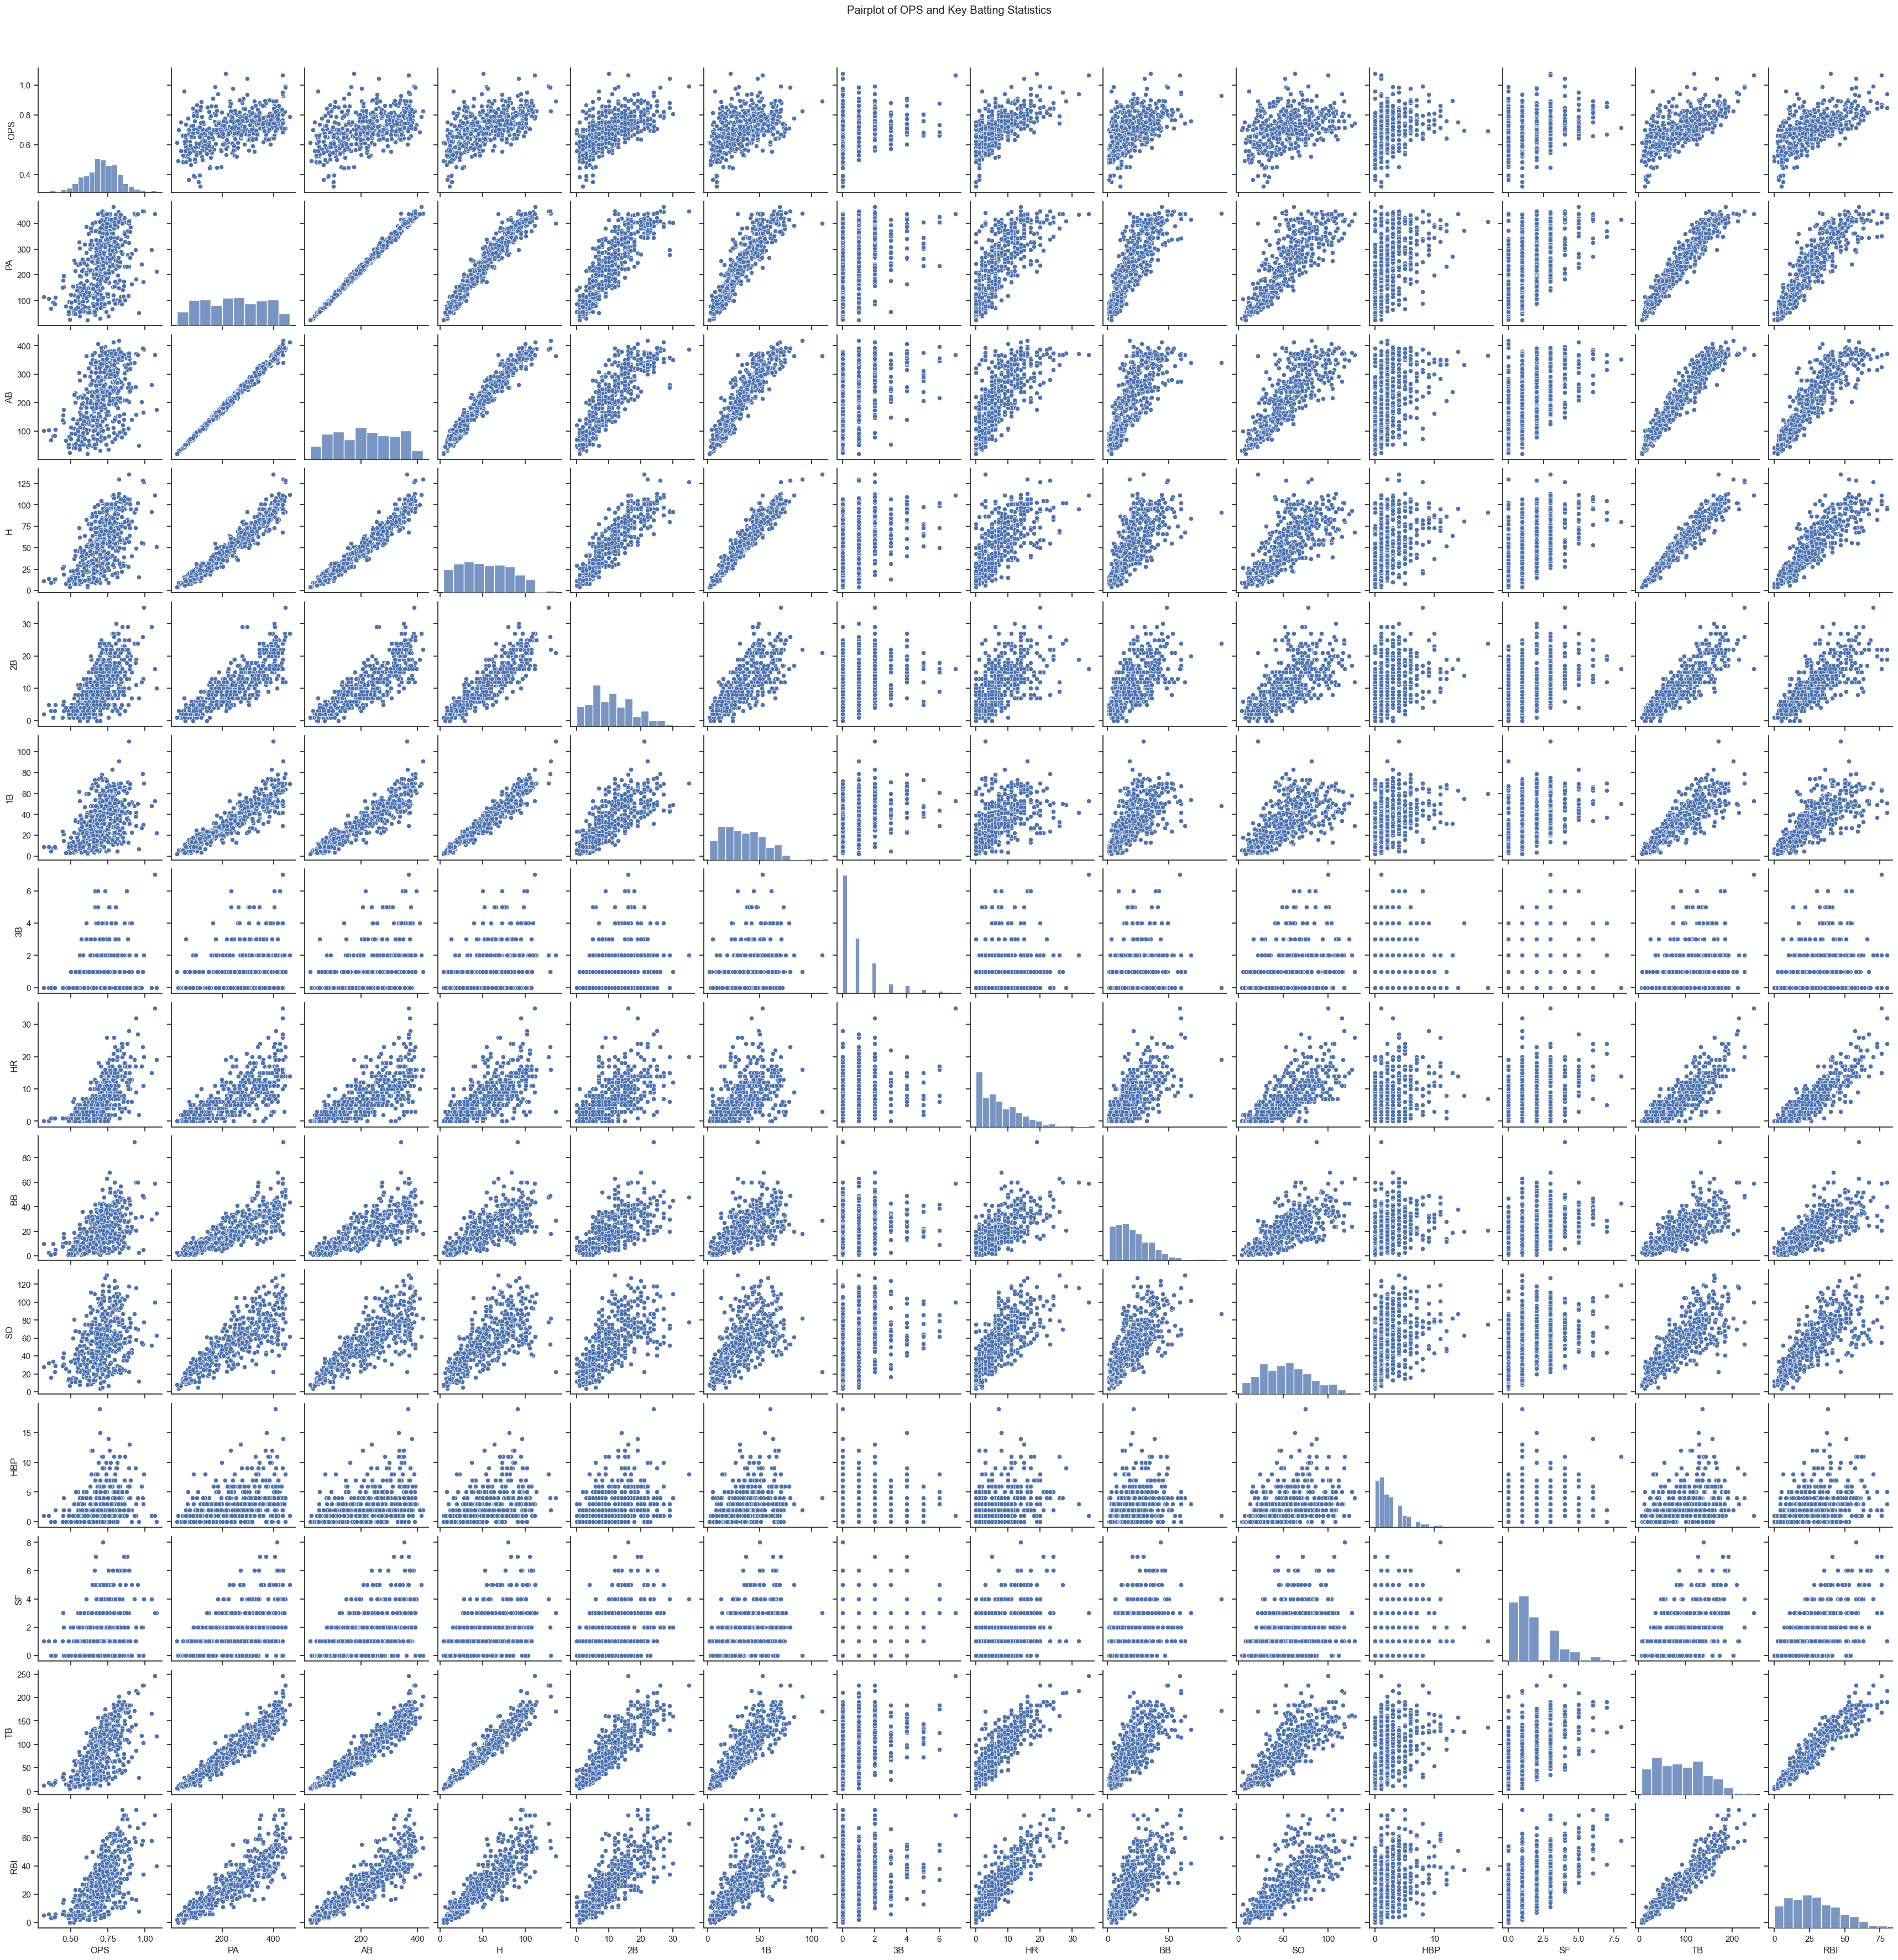

In [129]:
# Define relevant columns for OPS analysis
pairplot_cols = [
    'OPS', 'PA', 'AB', 'H', '2B', '3B', 'HR',
    'BB', 'SO', 'HBP', 'SF', 'TB', 'RBI'
]

# Calculate singles (1B)
dfMLB['1B'] = pd.to_numeric(dfMLB['H'], errors='coerce') - (
    pd.to_numeric(dfMLB['2B'], errors='coerce') +
    pd.to_numeric(dfMLB['3B'], errors='coerce') +
    pd.to_numeric(dfMLB['HR'], errors='coerce')
)

# Add '1B' to analysis columns
pairplot_cols.insert(5, '1B')  # insert after 'H'

# Convert all columns to numeric
for col in pairplot_cols:
    dfMLB[col] = pd.to_numeric(dfMLB[col], errors='coerce')

# Drop rows with any missing values
df_pair = dfMLB[pairplot_cols].dropna()

# Generate the pairplot
sns.set(style="ticks")
sns.pairplot(df_pair, height=2.5)
plt.suptitle("Pairplot of OPS and Key Batting Statistics", y=1.02)
plt.show()

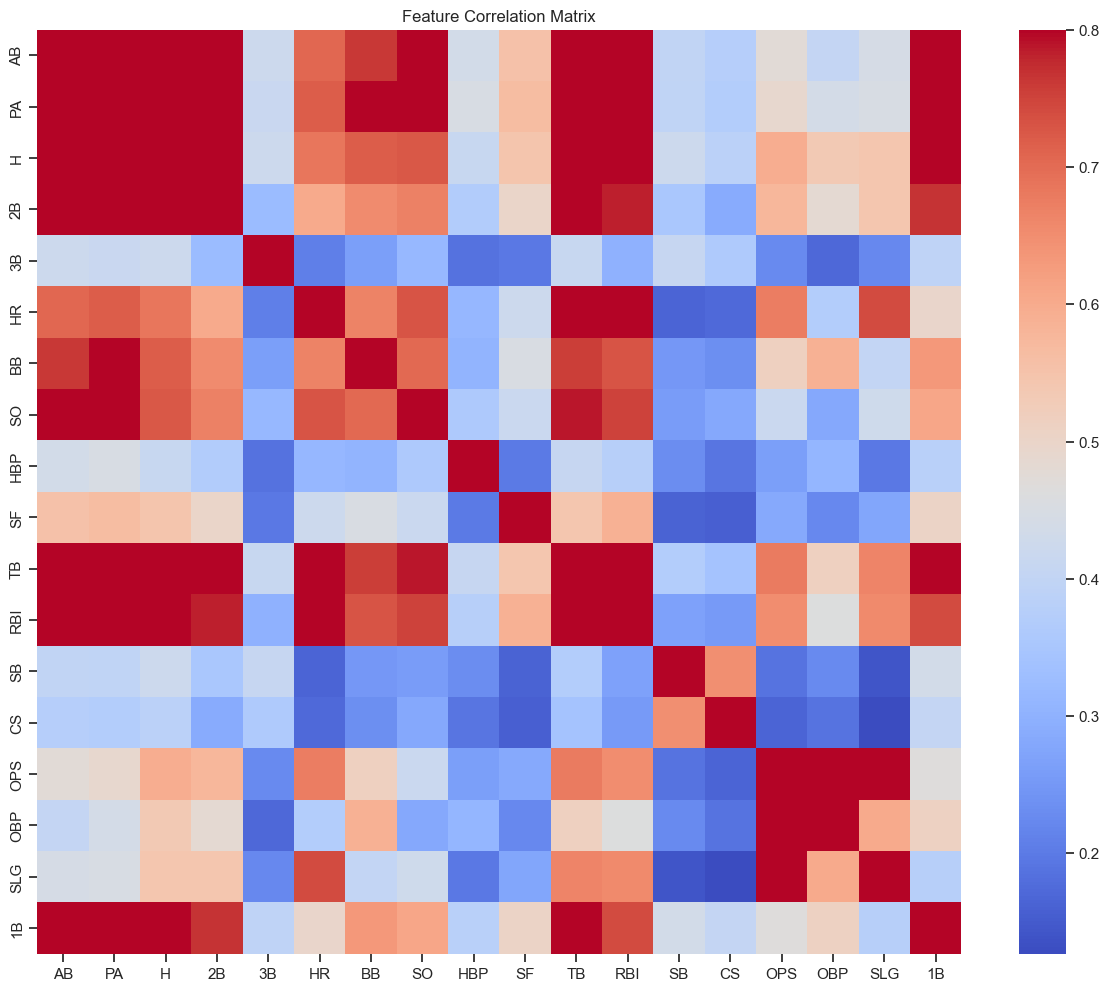

In [133]:
# Compute correlation matrix
dfMLB = dfMLB.select_dtypes(include=[np.number])
correlation_matrix = dfMLB.corr()

# Plot
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, vmax=0.8, square=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()